Congraturations on Baylor University and thanks for hosting this exciting competition!  

I ended up in the bronze medal, but want to share my simple solution, based on [starter kernel](https://www.kaggle.com/addisonhoward/basic-starter-kernel-ncaa-women-s-dataset-2019).  

My solution is not complicated:  

**It predicts the probability of the occurrence of the upset, which means that the low seed rank team beats the high seed rank team, aggregating past game results**  

In [26]:
import os; print(os.listdir("../input/stage2wdatafiles"))
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import log_loss

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

['WTeams.csv', 'WSeasons.csv', 'WRegularSeasonDetailedResults.csv', 'WNCAATourneySlots.csv', 'WNCAATourneyCompactResults.csv', 'WGameCities.csv', 'WNCAATourneySeeds.csv', 'WTeamSpellings.csv', 'WRegularSeasonCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WCities.csv']


## Preprocess

In [27]:
data_dir = '../input/stage2wdatafiles/'
df_seed = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_result = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')

df_seed.tail(3)
df_result.tail(3)

,Season,Seed,TeamID
1405,2019,Z14,3200
1406,2019,Z15,3340
1407,2019,Z16,3380


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1320,2018,151,3280,73,3257,63,N,1
1321,2018,151,3323,91,3163,89,N,1
1322,2018,153,3323,61,3280,58,N,0


In [28]:
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int

def clean_df(df_seed, df_result):
    df_seed['seed_int'] = df_seed['Seed'].apply(seed_to_int)
    df_seed.drop(['Seed'], axis=1, inplace=True)
    df_result.drop(['DayNum', 'WLoc', 'NumOT'], axis=1, inplace=True)
    return df_seed, df_result

df_seed, df_result = clean_df(df_seed, df_result)
df_seed.head(3)
df_result.head(3)

,Season,TeamID,seed_int
0,1998,3330,1
1,1998,3163,2
2,1998,3112,3


,Season,WTeamID,WScore,LTeamID,LScore
0,1998,3104,94,3422,46
1,1998,3112,75,3365,63
2,1998,3163,93,3193,52


In [29]:
## Merge seed for each team
def merge_seed_result(df_seed, df_result):
    df_win_seed = df_seed.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
    df_loss_seed = df_seed.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
    df_result = df_result.merge(df_win_seed, how='left', on=['Season', 'WTeamID'])
    df_result = df_result.merge(df_loss_seed, how='left', on=['Season', 'LTeamID'])
    df_result['SeedDiff'] = np.abs(df_result['WSeed'] - df_result['LSeed'])
    df_result['ScoreDiff'] = np.abs(df_result['WScore'] - df_result['LScore'])
    return df_result

df_result = merge_seed_result(df_seed, df_result)
df_result.head(3)

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDiff,ScoreDiff
0,1998,3104,94,3422,46,2,15,13,48
1,1998,3112,75,3365,63,3,14,11,12
2,1998,3163,93,3193,52,2,15,13,41


**Remove the games that end within 3 points difference, which are likely to be the other results**

In [30]:
df_result = df_result[df_result['ScoreDiff']>3]

## Upset Modeling

### Validation

**We can make use of the last competition for validating score**

- Train: 2009~2017  
- Test: 2018  

In [31]:
df_result['upset'] = [1 if ws > ls else 0 for ws, ls, in zip(df_result["WSeed"], df_result["LSeed"])]

print("upset probability")
df_result['upset'].value_counts() / len(df_result) * 100

upset probability


0    80.811496
1    19.188504
Name: upset, dtype: float64

**Use only last 10 seasons, since some trends are likely to be changed**

In [32]:
this_season=2019
total_season=10

train = df_result[ (df_result["Season"]>=(this_season - total_season)) & (df_result["Season"]<(this_season-1)) ]
print(train.shape)

(507, 10)


**The probability of the occurrence of the upset is likely to be different between a game 1st seed vs. 6th seed and a game 11th seed vs. 16th seed, so I want to include the information**

In [33]:
df_result["Seed_combi"]=[str(ws)+'_'+str(ls) if ws<ls else str(ls)+'_'+str(ws) for ws, ls in zip(df_result["WSeed"], df_result["LSeed"])]
df_result.head(3)

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDiff,ScoreDiff,upset,Seed_combi
0,1998,3104,94,3422,46,2,15,13,48,0,2_15
1,1998,3112,75,3365,63,3,14,11,12,0,3_14
2,1998,3163,93,3193,52,2,15,13,41,0,2_15


**Aggregation**

In [34]:
df_result_aggs = pd.DataFrame()
df_result_filter_aggs = pd.DataFrame()
df_result_season = df_result[ (df_result["Season"]>=(this_season - total_season)) & (df_result["Season"]<(this_season-1)) ]
for value in range(16):
    df_result_agg = df_result_season[df_result_season["SeedDiff"]==value].groupby("SeedDiff").agg({"upset": ["mean", "count"]})
    df_result_agg.columns = [col[0]+"_"+col[1]+"_"+"all" for col in df_result_agg.columns]
    df_result_filter_agg = df_result_season[df_result_season["SeedDiff"]==value].groupby("Seed_combi").agg({"upset": ["mean", "count"]})
    df_result_filter_agg.columns = [col[0]+"_"+col[1] for col in df_result_filter_agg.columns]
    if value==0:
        df_result_agg["upset_mean_all"] = 0.5
        df_result_filter_agg["upset_mean"] = 0.5
    df_result_aggs = pd.concat([df_result_aggs, df_result_agg])
    df_result_filter_aggs = pd.concat([df_result_filter_aggs, df_result_filter_agg])

df_result_aggs
df_result_filter_aggs.tail(10)

,upset_mean_all,upset_count_all
SeedDiff,,
0,0.500000,9
1,0.352273,88
2,0.125000,8
3,0.337662,77
4,0.185185,27
5,0.339286,56
6,0.000000,1
7,0.106383,47
8,0.208333,48


,upset_mean,upset_count
Seed_combi,,
3_11,0.500000,10
4_12,0.428571,7
1_10,0.000000,1
2_11,0.000000,4
4_13,0.032258,31
1_11,0.000000,1
1_12,0.000000,3
3_14,0.000000,35
2_15,0.000000,35


**Let's show barplot**

Text(0.5, 1.0, 'probability of upset based on past result aggretation')

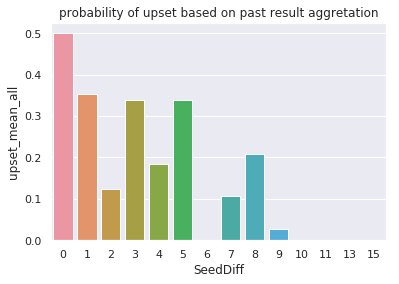

In [35]:
sns.barplot(df_result_aggs.index, df_result_aggs.upset_mean_all)
plt.title('probability of upset based on past result aggretation')
plt.show()

**Merge upset probability**

In [36]:
df_result = df_result.join(df_result_aggs, how='left', on="SeedDiff").join(df_result_filter_aggs, how='left', on='Seed_combi')
df_result["upset_prob"] = [m if c > 20 else a for a, m, c in zip(df_result["upset_mean_all"], df_result["upset_mean"], df_result["upset_count"])]
df_result.tail()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDiff,ScoreDiff,upset,Seed_combi,upset_mean_all,upset_count_all,upset_mean,upset_count,upset_prob
1316,2018,3257,76,3333,43,1,6,5,33,0,1_6,0.339286,56.0,0.000000,2.0,0.339286
1317,2018,3280,89,3417,73,1,3,2,16,0,1_3,0.125000,8.0,0.166667,6.0,0.125000
1318,2018,3163,94,3376,65,1,2,1,29,0,1_2,0.352273,88.0,0.190476,21.0,0.190476
1319,2018,3323,84,3332,74,1,2,1,10,0,1_2,0.352273,88.0,0.190476,21.0,0.190476
1320,2018,3280,73,3257,63,1,1,0,10,0,1_1,0.500000,9.0,0.500000,8.0,0.500000


**Scoring**

In [37]:
valid = df_result[ (df_result["Season"]==(this_season-1)) ]
log_loss(valid['upset'], valid['upset_prob'])

0.43238263398573873

**manual smoothing**

Text(0.5, 1.0, 'probability of upset based on past result aggretation')

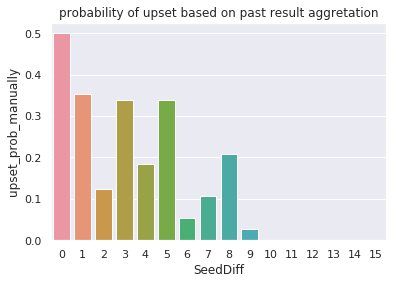

In [38]:
df_result_aggs.loc[0, 'upset_mean_all'] = 0.5
df_result_aggs.loc[6, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[7, 'upset_mean_all']) / 2
df_result_aggs.loc[12, 'upset_mean_all'] = 0.0
df_result_aggs.loc[14, 'upset_mean_all'] = 0.0
df_result_aggs = df_result_aggs.rename(columns={'upset_mean_all': 'upset_prob_manually'})

sns.barplot(df_result_aggs.index, df_result_aggs.upset_prob_manually)
plt.title('probability of upset based on past result aggretation')
plt.show()

In [39]:
valid.head(3)

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDiff,ScoreDiff,upset,Seed_combi,upset_mean_all,upset_count_all,upset_mean,upset_count,upset_prob
1260,2018,3124,96,3212,46,2,15,13,50,0,2_15,0.000000,35.0,0.000000,35.0,0.000000
1261,2018,3177,90,3328,79,5,12,7,11,0,5_12,0.106383,47.0,0.137931,29.0,0.137931
1262,2018,3257,74,3129,42,1,16,15,32,0,1_16,0.000000,36.0,0.000000,36.0,0.000000


**Scoring**

In [40]:
valid = df_result[ (df_result["Season"]==(this_season-1)) ]
valid = valid.join(df_result_aggs.drop("upset_count_all", axis=1), how='left', on='SeedDiff')
valid.fillna(0, inplace=True)
log_loss(valid['upset'], valid['upset_prob_manually'])

0.4586907283172499

**Clipping**

**for making the model conservative**

In [41]:
log_loss(valid['upset'], np.clip(valid['upset_prob_manually'], 0.05, 0.95))

0.47126162893684526

---

### Test

- Train: 2009~2018  
- Test: 2019

In [42]:
df_seed_2019 = df_seed[df_seed["Season"]==2019]

In [43]:
this_season=2019
total_season=10

train = df_result[ (df_result["Season"]>=(this_season - total_season)) ]
print(train.shape)

df_result["Seed_combi"]=[str(ws)+'_'+str(ls) if ws<ls else str(ls)+'_'+str(ws) for ws, ls in zip(df_result["WSeed"], df_result["LSeed"])]
df_result.head()

(567, 16)


,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDiff,ScoreDiff,upset,Seed_combi,upset_mean_all,upset_count_all,upset_mean,upset_count,upset_prob
0,1998,3104,94,3422,46,2,15,13,48,0,2_15,0.000000,35.0,0.000000,35.0,0.000000
1,1998,3112,75,3365,63,3,14,11,12,0,3_14,0.000000,38.0,0.000000,35.0,0.000000
2,1998,3163,93,3193,52,2,15,13,41,0,2_15,0.000000,35.0,0.000000,35.0,0.000000
3,1998,3198,59,3266,45,7,10,3,14,0,7_10,0.337662,77.0,0.312500,32.0,0.312500
5,1998,3234,77,3269,59,4,13,9,18,0,4_13,0.027778,36.0,0.032258,31.0,0.032258


In [44]:
df_result_aggs = pd.DataFrame()
df_result_filter_aggs = pd.DataFrame()
for value in range(16):
    df_result_agg = df_result[df_result["SeedDiff"]==value].groupby("SeedDiff").agg({"upset": ["mean", "count"]})
    df_result_agg.columns = [col[0]+"_"+col[1]+"_"+"all" for col in df_result_agg.columns]
    df_result_filter_agg = df_result[df_result["SeedDiff"]==value].groupby("Seed_combi").agg({"upset": ["mean", "count"]})
    df_result_filter_agg.columns = [col[0]+"_"+col[1] for col in df_result_filter_agg.columns]
    if value==0:
        df_result_agg["upset_mean_all"] = 0.5
        df_result_filter_agg["upset_mean"] = 0.5
    df_result_aggs = pd.concat([df_result_aggs, df_result_agg])
    df_result_filter_aggs = pd.concat([df_result_filter_aggs, df_result_filter_agg])

df_result_aggs
df_result_filter_aggs.tail(10)

,upset_mean_all,upset_count_all
SeedDiff,,
0,0.500000,21
1,0.412322,211
2,0.166667,24
3,0.284848,165
4,0.218182,55
5,0.287879,132
6,0.250000,4
7,0.109091,110
8,0.176471,119


,upset_mean,upset_count
Seed_combi,,
5_13,0.500000,4
1_10,0.000000,1
2_11,0.000000,10
4_13,0.051948,77
1_11,0.000000,1
1_12,0.000000,3
3_14,0.000000,81
1_13,0.000000,2
2_15,0.000000,83


Text(0.5, 1.0, 'probability of upset based on past result aggretation')

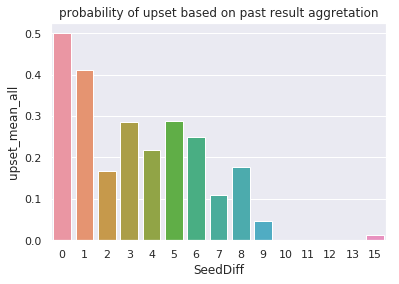

In [45]:
sns.barplot(df_result_aggs.index, df_result_aggs.upset_mean_all)
plt.title('probability of upset based on past result aggretation')
plt.show()

Text(0.5, 1.0, 'probability of upset based on past result aggretation')

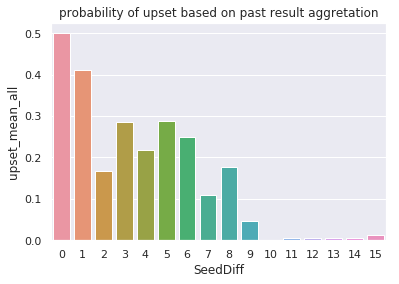

In [46]:
# manual smoothing
df_result_aggs.loc[0, 'upset_mean_all'] = 0.5
df_result_aggs.loc[10, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[11, 'upset_mean_all']) / 2
df_result_aggs.loc[11, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[15, 'upset_mean_all']) / 2
df_result_aggs.loc[12, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[15, 'upset_mean_all']) / 2
df_result_aggs.loc[13, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[15, 'upset_mean_all']) / 2
df_result_aggs.loc[14, 'upset_mean_all'] = (0.0 + df_result_aggs.loc[15, 'upset_mean_all']) / 2
df_result_aggs = df_result_aggs.fillna(-1)

sns.barplot(df_result_aggs.index, df_result_aggs.upset_mean_all)
plt.title('probability of upset based on past result aggretation')
plt.show()

In [47]:
test = pd.read_csv("../input/WSampleSubmissionStage2.csv")
test = pd.DataFrame(np.array([ID.split("_") for ID in test["ID"]]), columns=["Season", "TeamA", "TeamB"], dtype=int)
test.head(3)

test = test.merge(df_seed_2019, how='left', left_on=["Season", "TeamA"], right_on=["Season", "TeamID"])
test = test.rename(columns={"seed_int": "TeamA_seed"}).drop("TeamID", axis=1)

test = test.merge(df_seed_2019, how='left', left_on=["Season", "TeamB"], right_on=["Season", "TeamID"])
test = test.rename(columns={"seed_int": "TeamB_seed"}).drop("TeamID", axis=1)

test['SeedDiff'] = np.abs(test.TeamA_seed - test.TeamB_seed)
test.head(3)

,Season,TeamA,TeamB
0,2019,3101,3113
1,2019,3101,3114
2,2019,3101,3120


,Season,TeamA,TeamB,TeamA_seed,TeamB_seed,SeedDiff
0,2019,3101,3113,16,5,11
1,2019,3101,3114,16,12,4
2,2019,3101,3120,16,10,6


In [48]:
test["Seed_combi"]=[str(a)+'_'+str(b) if a<b else str(b)+'_'+str(a) for a, b in zip(test["TeamA_seed"], test["TeamB_seed"])]
test.head()

test = test.join(df_result_aggs, how='left', on="SeedDiff").join(df_result_filter_aggs, how='left', on='Seed_combi').fillna(-1)
test["upset_prob"] = [m if c > 20 else a for a, m, c in zip(test["upset_mean_all"], test["upset_mean"], test["upset_count"])]

# convert upset_prob to win_prob
test["win_prob"] = [(1-upset_prob) if teamA<teamB else upset_prob if teamA>teamB else 0.5 
                    for teamA, teamB, upset_prob in zip(test['TeamA_seed'], test['TeamB_seed'], test['upset_prob'])]
test.tail()

,Season,TeamA,TeamB,TeamA_seed,TeamB_seed,SeedDiff,Seed_combi
0,2019,3101,3113,16,5,11,5_16
1,2019,3101,3114,16,12,4,12_16
2,2019,3101,3120,16,10,6,10_16
3,2019,3101,3124,16,1,15,1_16
4,2019,3101,3125,16,13,3,13_16


,Season,TeamA,TeamB,TeamA_seed,TeamB_seed,SeedDiff,Seed_combi,upset_mean_all,upset_count_all,upset_mean,upset_count,upset_prob,win_prob
2011,2019,3413,3417,15,6,9,6_15,0.045455,88.0,-1.0,-1.0,0.045455,0.045455
2012,2019,3413,3460,15,13,2,13_15,0.166667,24.0,-1.0,-1.0,0.166667,0.166667
2013,2019,3416,3417,12,6,6,6_12,0.250000,4.0,-1.0,-1.0,0.250000,0.250000
2014,2019,3416,3460,12,13,1,12_13,0.412322,211.0,-1.0,-1.0,0.412322,0.587678
2015,2019,3417,3460,6,13,7,6_13,0.109091,110.0,-1.0,-1.0,0.109091,0.890909


In [49]:
submit = pd.read_csv("../input/WSampleSubmissionStage2.csv")
submit["Pred"] = test['win_prob']
submit.to_csv("submission_agg_all_manually_noclip.csv", index=False)
submit.head()

,ID,Pred
0,2019_3101_3113,0.005952
1,2019_3101_3114,0.218182
2,2019_3101_3120,0.250000
3,2019_3101_3124,0.011905
4,2019_3101_3125,0.284848


In [50]:
clipped_sub = np.clip(test['win_prob'], 0.05, 0.95)

submit = pd.read_csv("../input/WSampleSubmissionStage2.csv")
submit["Pred"] = clipped_sub
submit.to_csv("submission_agg_all_manually_cliped.csv", index=False)
submit.head()

,ID,Pred
0,2019_3101_3113,0.050000
1,2019_3101_3114,0.218182
2,2019_3101_3120,0.250000
3,2019_3101_3124,0.050000
4,2019_3101_3125,0.284848
